<a href="https://colab.research.google.com/github/anna-dang/dsc-phase-4-project/blob/main/project_4_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision: X-Ray Classification using Neural Networks

Objective: Build a model that can classify whether a given patient has pneumonia, given a chest x-ray image.

Sources: [original image source](http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5), [data download source](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)


### Import libraries

In [300]:
import os, random, cv2 

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
from sklearn import metrics
from lime import lime_image

from tensorflow.keras import callbacks, models, layers, optimizers, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

seed = 3
np.random.seed(seed)

### Define functions

In [341]:
def get_num_images(file_path, form='total'):
    """ Follows a filepath for this dataset and counts the images per class of NORMAL or PNEUMONIA X-rays.
        Option to return the 'total' elements per folder or a 'tuple' of the count for each type,
        or the 'normed' count (percentage per class of total).

        Output format: (NORMAL, PNEUMONIA) """    

    # Calculate quantities
    normal = len(os.listdir(file_path + '/NORMAL'))
    pneum = len(os.listdir(file_path + '/PNEUMONIA'))
    tot = normal + pneum

    # Format return type
    if form == 'total':
        return tot
    if form == 'normed':
        return tuple(round(i, 3) for i in ((normal/tot), (pneum/tot)))
    if form == 'tuple':
        return (normal, pneum) 


def plot_raw_images(samples):
    """ Displays selected number of raw images direct from training file for each class."""

    # Randomly select images from both classes to inspect
    pneu_imgs = np.random.choice(os.listdir(train_path + '/PNEUMONIA/'), samples, replace = False)
    norm_imgs = np.random.choice(os.listdir(train_path + '/NORMAL/'), samples, replace = False)
  
    # Plot images
    fig, axes = plt.subplots(nrows=2, ncols=samples, figsize=(25, 25))
    for i, img in enumerate(norm_imgs):
        axes[0, i].imshow(cv2.imread(train_path + '/NORMAL/' + img))
        axes[0, i].set_title(f"Normal Lungs, {i + 1}")
    for i, img in enumerate(pneu_imgs):   
        axes[1, i].imshow(cv2.imread(train_path + '/PNEUMONIA/' + img))
        axes[1, i].set_title(f"Pnuemonia Lungs, {i + 1}")
    plt.subplots_adjust(bottom=0.3, top=0.6, hspace=0)
    plt.show()



def plot_metrics(history, df=False):
    """ Input model history (from 'model.fit'), 
        Return visualizations for pre-defined metrics.
        Option to return training history DataFrame."""

    metrics = ['loss', 'accuracy', 'precision', 'recall']
    plt.figure(figsize=(12,8))
    # plot train vs test for each metric
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='indigo', 
                 label='Train', zorder=3)
        plt.plot(history.epoch, history.history['val_'+metric], color='steelblue', 
                 label='Validate', linestyle="--", zorder=5)
        plt.grid(color='whitesmoke', zorder=0)
        plt.xlabel('Epoch')
        plt.ylabel(name, size=12)
        plt.legend()
        plt.suptitle("Model Training Performance")
    if df == True:
        pd.DataFrame(history.history)
      

def plot_roc_auc(model, images, labels):
    """ Given a model and test data, evaluates the model's discrimination
        between 'true-positive rate' and 'false-positive rate'.

        Plots an ROC curve: TPR vs. FPR at different classification thresholds.
        
        The AUC value lies between 0.5 and 1,
        where 0.5 is a bad classifer and 1 is an excellent classifier """

    # Predict with model
    test_hat = model.predict(images).round()

    # Calculate 'false-positive rate' and 'true-positive rate'
    fpr , tpr , thresholds = metrics.roc_curve(labels, test_hat)

    # Calculate 'area under curve'
    auc_score = metrics.roc_auc_score(labels, test_hat)

    # Plot ROC curve, print AUC in title
    plt.plot(fpr,tpr, color='indigo') 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title(f"ROC Curve, AUC: {round(auc_score, 3}", size=15)
    plt.grid(color='whitesmoke', zorder=0)
    plt.show()



def evaluate_model(model, images, labels, return_preds=False, norm_type='true'):
    """ Given model and predictors/labels, returns model performance evaluation
        as Classification Report Table and two confusion matrices (one with 
        prediction class distribution and one normalized (default: 'true').

        Optional: return predicted labels."""

    # Get binary predictions by round predicted probabilities
    y_hat= model.predict(images).round()
    
    # Print classification report
    print("---"*20)
    print("Classification Report for Test Data: \n")
    print(metrics.classification_report(labels, y_hat))
    print("---"*12)
    
    # Build confusion matrix
    print("Model Predictions Results for Test Data:")
    cm = metrics.confusion_matrix(labels, y_hat, normalize='all')
    cm_true = metrics.confusion_matrix(labels, y_hat, normalize='true')

    # Plot quantity distribution confusion matrix
    plt.figure(figsize=(3,3));
    ax1 = sns.heatmap(cm, annot=True, fmt='.0%', cmap="BuPu", square=True)
    ax1.set(title='Distribution of Predictions',ylabel='True Class', xlabel='Predicted Class')

    # Plot normalized matrix (to ROWS, true values)
    plt.figure(figsize=(3,3));
    ax2 = sns.heatmap(cm_true, annot=True, fmt='.0%', cmap="BuPu", square=True)
    ax2.set(title='Normalized to True Class',ylabel='True Class', xlabel='Predicted Class')

    # If selected, return predicted labels
    if return_preds == True:
        return y_hat





In [ ]:
# custome ROC to plot as subplot

def plot_roc_auc(model, images, labels, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, y, **plt_kwargs) ## example plot here
    

    # Predict with model
    test_hat = model.predict(images).round()

    # Calculate 'false-positive rate' and 'true-positive rate'
    fpr , tpr , thresholds = metrics.roc_curve(labels, test_hat)

    # Calculate 'area under curve'
    auc_score = metrics.roc_auc_score(labels, test_hat)

    # Plot ROC curve, print AUC in title
    ax.plot(fpr,tpr, color='indigo') 
    ax.axis([0,1,0,1]) 
    ax.xlabel('False Positive Rate') 
    ax.ylabel('True Positive Rate') 
    ax.title(f"ROC Curve, AUC: {round(auc_score, 3}", size=15)
    ax.grid(color='whitesmoke', zorder=0)

    return(ax)



def test_evaluate_model_1(model, images, labels, return_preds=False, norm_type='true'):

    ######### if this works modify tot 3 plots!!

    # Get binary predictions by round predicted probabilities
    y_hat= model.predict(images).round()
    
    # Print classification report
    print("---"*20)
    print("Classification Report for Test Data: \n")
    print(metrics.classification_report(labels, y_hat))
    print("---"*12)
    
    # Build confusion matrix
    print("Model Predictions Results for Test Data:")
    cm = metrics.confusion_matrix(labels, y_hat, normalize='all')
    cm_true = metrics.confusion_matrix(labels, y_hat, normalize='true')

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(18,16) )

    sns.heatmap(cm, annot=True, fmt='.0%', cmap="BuPu", square=True, ax=ax1)
    sns.heatmap(cm_true, annot=True, fmt='.0%', cmap="BuPu", square=True, ax=ax2)
    plot_roc_auc(model, images, labels, ax=ax4)

    ax1.set(title='Distribution of Predictions',ylabel='True Class', xlabel='Predicted Class')
    ax2.set(title='Normalized to True Class',ylabel='True Class', xlabel='Predicted Class')
    ax3.plot_roc_auc(model, images, labels)

    # If selected, return predicted labels
    if return_preds == True:
        return y_hat


def test_evaluate_model_2(model, images, labels, return_preds=False, norm_type='true'):
    """ Given model and predictors/labels, returns model performance evaluation
        as Classification Report Table and two confusion matrices (one with 
        prediction class distribution and one normalized (default: 'true').

        Optional: return predicted labels."""

    # Get binary predictions by round predicted probabilities
    y_hat= model.predict(images).round()
    
    # Print classification report
    print("---"*20)
    print("Classification Report for Test Data: \n")
    print(metrics.classification_report(labels, y_hat))
    print("---"*12)
    
    # Build confusion matrix
    print("Model Predictions Results for Test Data:")
    cm = metrics.confusion_matrix(labels, y_hat, normalize='all')
    cm_true = metrics.confusion_matrix(labels, y_hat, normalize='true')

    # Set figure
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,16) )

    # Plot quantity distribution confusion matrix
    sns.heatmap(cm, annot=True, fmt='.0%', cmap="BuPu", square=True, ax=ax1)
    ax1.set(title='Distribution of Predictions',ylabel='True Class', xlabel='Predicted Class')

    # Plot normalized matrix (to ROWS, true values)
    sns.heatmap(cm_true, annot=True, fmt='.0%', cmap="BuPu", square=True, ax=ax2)
    ax2.set(title='Normalized to True Class',ylabel='True Class', xlabel='Predicted Class')

    # If selected, return predicted labels
    if return_preds == True:
        return y_hat



### Download data

In [4]:
# Mount the connection to Google Drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [5]:
# Check current directory (the 'local' directory where Colab operates)
os.getcwd()

'/content'

In [263]:
# Define 'local' path as the directory of the virtual machine (where Colab runs)
local_path = '/content'

# Path to this project fold gdrive to save any models/variables
project_path = '/gdrive/MyDrive/mod04/'

# Path where data .zip file is stored on Google Drive
zip_path = '/gdrive/MyDrive/kaggle/chest-xray-pneumonia.zip'

# Copy .zip file into virtual machine
!cp '{zip_path}' .

^C


In [7]:
# Unzip in virtual machine/pwd
!unzip -q 'chest-xray-pneumonia.zip'

In [8]:
# Establish file paths for each of the unzipped data folders on the virtual machine
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
val_path = '/content/chest_xray/val'

# Count images per path
[get_num_images(path, form='total') for path in [train_path, test_path, val_path]]

[5216, 624, 16]

In [9]:
# Quick examine of the class distribution for each set as items and then percentage split
# Tuple presented as (Normal, Pneumonia)
display([x.split('/')[-1] for x in [train_path, test_path, val_path]])
display([get_num_images(path, form='tuple') for path in [train_path, test_path, val_path]])
[get_num_images(path, form='normed') for path in [train_path, test_path, val_path]]

['train', 'test', 'val']

[(1341, 3875), (234, 390), (8, 8)]

[(0.257, 0.743), (0.375, 0.625), (0.5, 0.5)]

### Preview data

There are two main class types: 'Normal' (class 0) and 'Pneumonia' (class 1). 

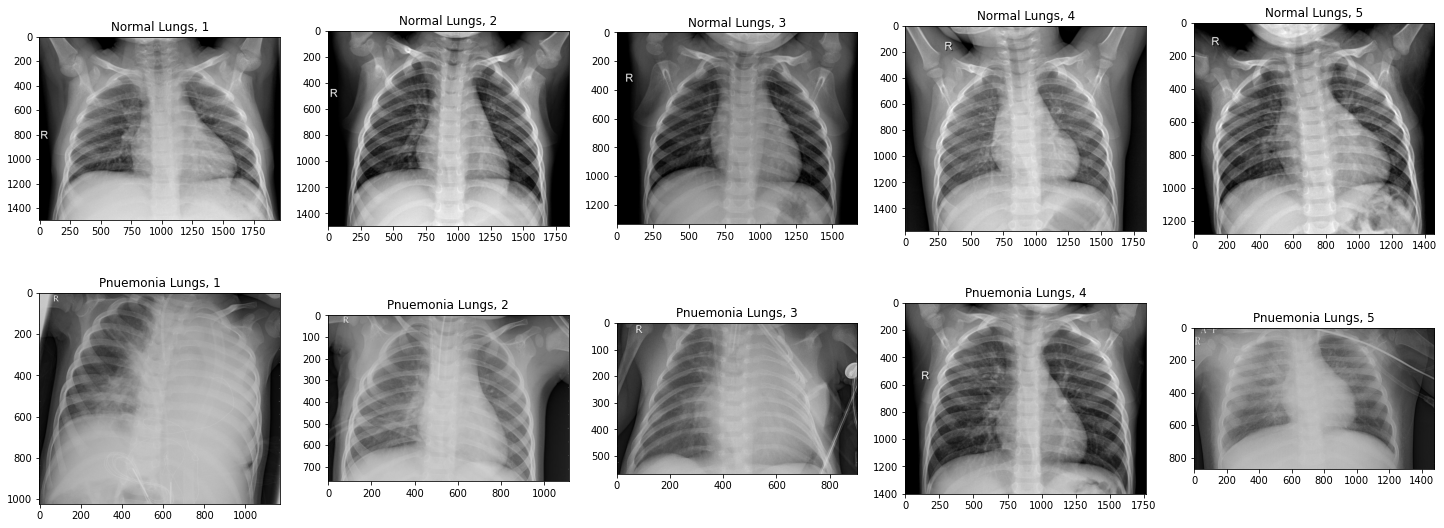

In [262]:
# Select number of images
samples = 5

# Preview unprocessed images sized to fit in single row (keep original aspect ratio)
plot_raw_images(samples)

Without medical traing and just a visual inspection - we see somewhat more opacity in the pneumonia lungs. This could be part of the pattern the model will recognize.


In [267]:
# Check original image pixel dimensions
# Check number of pixel channels (the third dimension) to determine if RGB or grayscale
print([cv2.imread(train_path + '/NORMAL/' + img).shape for img in norm_imgs])
print([cv2.imread(train_path + '/PNEUMONIA/' + img).shape for img in pneu_imgs])

[(1133, 1476, 3), (1067, 1438, 3), (1437, 1802, 3), (1237, 1512, 3), (1615, 1890, 3)]
[(912, 1616, 3), (616, 816, 3), (1160, 1432, 3), (1200, 1632, 3), (951, 1342, 3)]


Note there is a variety in image dimensions (image size is not standardized) and there are 3 color channels. Indicating that while these X-rays appear gray, they should be treated as full RGB for the model. The resolution is too large for training resources so the images will be resized to the smallest size without sacrificing model performance.

# Modeling


### Class Imbalance




On first inspection the training data is heavily unbalanced, favoring pnuemonia images. This could skew the training of the model as it will not be sufficiently trained on what 'normal' lungs look like compared to the pneumonia lungs. Data-oversampling and class weighting are equivalent. Copying the samples of a class 3X is equivalent to assigning a 3X weight to the class. However, the weighting is better from storage and computational point of view since it avoids working with a larger data-set. I will correct this balance by calculating class weights to train the model with.

,Quantity,Proportion
Normal,1341,0.257
Pneumonia,3875,0.743


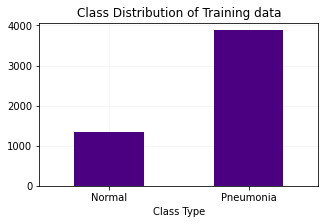



Pneumonia is represented 2.89 times as much by the data.


In [342]:
# Display proportion by class for training set
normed = get_num_images(train_path, form='normed')
total = get_num_images(train_path, form='tuple')
total_s = pd.Series(data={'Normal': total[0], 'Pneumonia': total[1]}, name= 'Quantity').to_frame()
norm_s = pd.Series(data={'Normal': normed[0], 'Pneumonia': normed[1]}, name= 'Proportion').to_frame()
class_frame = pd.concat([total_s, norm_s], axis=1)
display(class_frame)
print('\n')

# Plot the distribution as a bar graph
class_frame['Quantity'].plot.bar(figsize=(5,3), legend=False, rot=0, 
                                 color='indigo', zorder=3)
plt.title('Class Distribution of Training data')
plt.xlabel("Class Type")
plt.ylabel("Quantity")
plt.grid(color="whitesmoke", zorder=0)
plt.show()

print("\n")
print(f"Pneumonia is represented {round(total[1]/total[0], 2)} times as much by the data.")

In [260]:
# Set class weights according to Keras documentation
weight_for_0 = (1 / total[0])*(get_num_images(train_path, form='total'))/2.0 
weight_for_1 = (1 / total[1])*(get_num_images(train_path, form='total'))/2.0

class_weight = {0.0: weight_for_0, 1.0: weight_for_1}

print('Weight for class 0 (Normal): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Pnuemonia): {:.2f}'.format(weight_for_1))

Weight for class 0 (Normal): 1.94
Weight for class 1 (Pnuemonia): 0.67


### Metrics

Which type of wrong answers are most concerning:

- Accuracy is the percentage of examples correctly classified

- Precision is the percentage of predicted positives that were correctly classified

- Recall is the percentage of actual positives that were correctly classified. Model guessing all target class will get a 100% recall.

In disease screening of patients for follow-up examinations, we would probably want a recall near 1.0 — we want to find all patients who actually have the disease so treatment can beging. We can accept a low precision if the cost of the follow-up examination is not significant. However, in cases where we want to find an optimal blend of precision and recall we can combine the two metrics and check F1 score on the test set.

In [17]:
mod_metrics = ['accuracy', 
               tf.keras.metrics.Precision(name='precision'), 
               tf.keras.metrics.Recall(name='recall')]       


### Callbacks


A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

- Early Stopping: Stop training when a monitored metric has stopped improving.

- Save model weights at some frequency or "best performance".

-


```
# To save models
model_path_filename = project_path +'model.hd5'
model.save(model_path_filename)

# Load model
model_loaded = load_model(model_path_filename)

# Load weights (that are considered the best) into the model
model.load_weights(checkpoint_filepath)
```

In [268]:
# Set baseline call backs
earlystop = callbacks.EarlyStopping(verbose=1, 
                                    monitor='val_accuracy', 
                                    min_delta=0.01, 
                                    patience=3)

checkpoint = callbacks.ModelCheckpoint(filepath=project_path+"weights.{epoch:02d}-{val_accuracy:.2f}.hdf5",
                                       save_weights_only=True, 
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)

call_list = [earlystop, checkpoint]

## Modeling

Convolutional Neural Networks (CNN)


#### CNN Preprocessing

In [275]:
# Set image size, validation split percentage
target_img_size = (128, 128)
val_split_size = 0.25

# Rescale images to reduce RBG values to between 0 and 1
# Instantiate training set image generator
train_datagen = ImageDataGenerator(rescale=(1./255))
                                   
# Data used to train model
print(" Train:")
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size=target_img_size,
                                                    batch_size=32, #get_num_images(train_path))  
                                                    class_mode='binary',
                                                    seed=seed) 

# Blind test data for model evaluation, no modifications (except rescale)
# Split into test/validation split, label the subsets
test_val_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split_size)  

# Data for use as validation in modeling to score model performance
print("\n Validation:")
val_generator = train_datagen.flow_from_directory(train_path, 
                                                      target_size=target_img_size,
                                                      class_mode='binary',
                                                      batch_size=32, #get_num_images(test_path),
                                                      subset='validation', 
                                                      seed=seed) 

# Data for testing completed model
print("\n Test:")
test_generator = test_datagen.flow_from_directory(test_path, 
                                                      target_size=target_img_size,
                                                      class_mode='binary',
                                                      batch_size=32, #get_num_images(test_path),
                                                      subset='training',
                                                      seed=seed)  

# Check for class types
print("\n Class Types:", train_generator.class_indices )

 Train:
Found 5216 images belonging to 2 classes.

 Validation:
Found 124 images belonging to 2 classes.

 Test:
Found 500 images belonging to 2 classes.

 Class Types: {'NORMAL': 0, 'PNEUMONIA': 1}


In [276]:
# Verify image size plus 3 RGB channels
input_image_size = (target_img_size[0], target_img_size[1], 3)
input_image_size

(128, 128, 3)

#### Iteration 1 : Baseline CNN

In [277]:
cnn1 = Sequential()
# First Conv layer
cnn1.add(Conv2D(64, (3, 3), input_shape = input_image_size, activation = 'relu'))
cnn1.add(Conv2D(64, (3, 3), activation = 'relu'))
cnn1.add(MaxPooling2D(pool_size = (2, 2)))
# Second Conv layer
cnn1.add(Conv2D(32, (3, 3), activation = 'relu'))
cnn1.add(MaxPooling2D(pool_size = (2, 2)))
# Flatten the Conv layers for input into dense layer
cnn1.add(Flatten())
# A hidden dense layer followed by the final binary classifying neuron
cnn1.add(Dense(units = 64, activation = 'relu'))
cnn1.add(Dense(units = 1, activation = 'sigmoid'))

# Compile the model and check architecture
cnn1.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)
cnn1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 60, 60, 32)        18464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)               

In [279]:
# Train the model
history1 = cnn1.fit(train_generator, 
                              #steps_per_epoch=100, 
                              epochs=15, 
                              validation_data=val_generator,
                              class_weight=class_weight,
                              callbacks=call_list)

Epoch 1/15
163/163 [==============================] - 53s 327ms/step - loss: 0.2901 - accuracy: 0.8673 - precision: 0.9521 - recall: 0.8646 - val_loss: 0.3510 - val_accuracy: 0.8226 - val_precision: 0.8043 - val_recall: 0.9487
Epoch 2/15
163/163 [==============================] - 53s 324ms/step - loss: 0.1195 - accuracy: 0.9530 - precision: 0.9858 - recall: 0.9505 - val_loss: 0.7504 - val_accuracy: 0.7419 - val_precision: 0.7091 - val_recall: 1.0000
Epoch 3/15
163/163 [==============================] - 52s 322ms/step - loss: 0.0883 - accuracy: 0.9676 - precision: 0.9905 - recall: 0.9657 - val_loss: 0.8464 - val_accuracy: 0.7500 - val_precision: 0.7156 - val_recall: 1.0000
Epoch 4/15
163/163 [==============================] - 53s 325ms/step - loss: 0.0739 - accuracy: 0.9722 - precision: 0.9921 - recall: 0.9703 - val_loss: 0.9707 - val_accuracy: 0.7339 - val_precision: 0.7027 - val_recall: 1.0000
Epoch 00004: early stopping


------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.96      0.34      0.50       188
         1.0       0.71      0.99      0.83       312

    accuracy                           0.75       500
   macro avg       0.83      0.67      0.67       500
weighted avg       0.80      0.75      0.71       500

------------------------------------
Model Predictions Results for Test Data:


None

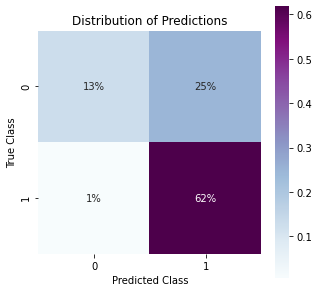

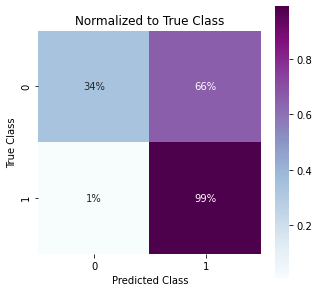

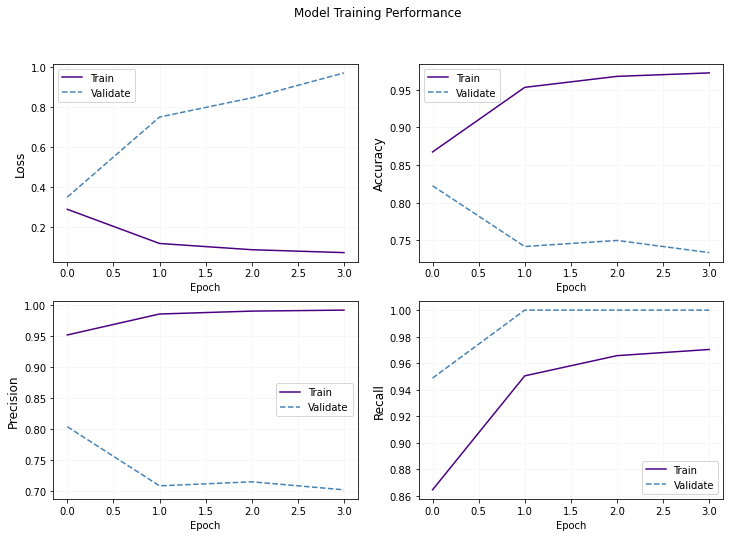

In [339]:
# Evaluate model performance
display(evaluate_model(cnn1, test_images, test_labels))
plot_metrics(history1)
plot_roc_auc(cnn1, test_images, test_labels)

In [ ]:
# TEST
test_evaluate_model_2(cnn1, test_images, test_labels)

In [ ]:
# TEST
test_evaluate_model_1(cnn1, test_images, test_labels)

In [ ]:
# TEST
plot_roc_auc(cnn1, test_images, test_labels, ax=None)

#### Iteration 2 :

In [68]:

cnn2 = Sequential([Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same',input_shape=input_image_size),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Conv2D(16, kernel_size=(5, 5), activation='relu'),
                  MaxPooling2D(pool_size=(2, 2), strides=2),
                  Flatten(),
                  Dense(120, activation='relu'),
                  Dense(84, activation='relu'),
                  Dense(1, activation = 'sigmoid')])

cnn2.compile(optimizer = 'adam', 
                loss = 'binary_crossentropy',
                metrics = mod_metrics)
cnn2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 16)        3216      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 120)               1728120   
_________________________________________________________________
dense_13 (Dense)             (None, 84)               

In [282]:
history2 = cnn2.fit(train_generator,
                              epochs = 10, 
                              validation_data = val_generator,
                              callbacks = call_list,
                              class_weight=class_weight)

Epoch 1/10
163/163 [==============================] - 53s 323ms/step - loss: 0.1165 - accuracy: 0.9569 - precision: 0.9856 - recall: 0.9559 - val_loss: 0.9371 - val_accuracy: 0.7258 - val_precision: 0.6964 - val_recall: 1.0000
Epoch 2/10
163/163 [==============================] - 52s 317ms/step - loss: 0.0933 - accuracy: 0.9670 - precision: 0.9910 - recall: 0.9644 - val_loss: 0.4493 - val_accuracy: 0.8226 - val_precision: 0.7800 - val_recall: 1.0000
Epoch 3/10
163/163 [==============================] - 51s 314ms/step - loss: 0.0633 - accuracy: 0.9770 - precision: 0.9937 - recall: 0.9752 - val_loss: 0.5128 - val_accuracy: 0.8548 - val_precision: 0.8125 - val_recall: 1.0000
Epoch 4/10
163/163 [==============================] - 51s 312ms/step - loss: 0.0577 - accuracy: 0.9772 - precision: 0.9929 - recall: 0.9763 - val_loss: 0.5547 - val_accuracy: 0.8226 - val_precision: 0.7800 - val_recall: 1.0000
Epoch 5/10
163/163 [==============================] - 50s 306ms/step - loss: 0.0496 - accura

------------------------------------------------------------
Classification Report for Test Data: 

              precision    recall  f1-score   support

         0.0       0.96      0.28      0.44       188
         1.0       0.70      0.99      0.82       312

    accuracy                           0.73       500
   macro avg       0.83      0.64      0.63       500
weighted avg       0.80      0.73      0.68       500

------------------------------------
Model Predictions Results for Test Data:


None

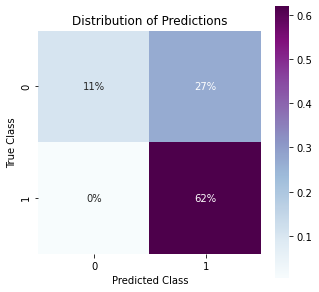

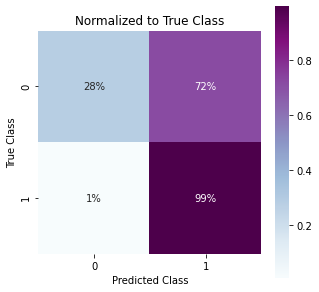

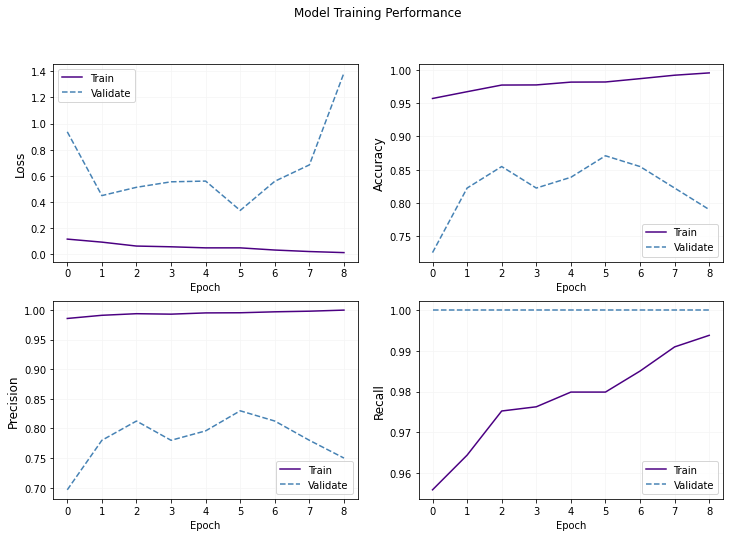

In [340]:
display(evaluate_model(cnn2, test_images, test_labels))
plot_metrics(history2)

### Iteration : Image Augmentation
Data augmentation is the process of changing the training samples and adding them back into the set. It is used for enriching the diversity of training samples

In [ ]:
# Instantiate training set image generator
train_datagen_aug = ImageDataGenerator(rescale=(1./255)) # ADD AUGS
                                   
# Data used to train model
print(" Train:")
train_data_aug = train_datagen_aug.flow_from_directory(train_path, 
                                                    target_size=target_img_size,
                                                    batch_size=32, #get_num_images(train_path))  
                                                    class_mode='binary',
                                                    seed=seed) 

#### Iteration : Image Size

### Iteration : Class imbalance manually corrected

TRY:
artifical up sample

downsample instead of weights

### Iteration : Regularize

Ideally, we are now at a place where we have a large model that is fitting at least the training set. Now it is time to regularize it and gain some validation accuracy by giving up some of the training accuracy. Some tips & tricks:

#### Iteration : Transfer Data / Pre-Train

# Evaluation


In [ ]:
# Print summary of final model

### Preprocess evalution images

Preprocess evalution images from untouched downloaded validation set of 16 image. Blind to all previous programming.

In [360]:
# Preprocessing validation images the same as the model to use to predict
val_datagen = ImageDataGenerator(rescale=(1./255))
val_data = val_datagen.flow_from_directory(val_path, 
                                            target_size=target_img_size,
                                            batch_size=get_num_images(val_path),
                                            class_mode='binary')

# Get the images and labels as np.arrays                                          
val_imgs, val_labels = next(val_data)
val_key = val_data.class_indices
val_key

Found 16 images belonging to 2 classes.


{'NORMAL': 0, 'PNEUMONIA': 1}

In [368]:
# Flip dict to be able to search by predicted class as key
pred_key = {value:key for key, value in val_key.items()}
pred_key

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [418]:
# Select a random training image and label to evalute
i = np.random.choice(range(len(val_labels)))
label = val_labels[i]
img = val_imgs[i]

# Format as 4D tensor for feature mapping
img_tensor = np.expand_dims(val_imgs[i], axis=0)
img_tensor.shape

(1, 128, 128, 3)

### Visualize intermediate layers

In [402]:
###TTOOODDDOOOOO: update with final model

# Load final model, examine arhitecture
# fin_model = load_model('chest_xray_all_data.h5')
# fin_model.summary() 
cnn1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 60, 60, 32)        18464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)               

In [ ]:
###TTOOODDDOOOOO: update with final model

# Count convolution/pooling layers in model summary (everything before 'flat') 
n = 5

# Extract model layer outputs
layer_outputs = [layer.output for layer in cnn1.layers[:n]]
layer_outputs
# Make a model to display the feature maps
activation_model = models.Model(inputs=cnn1.input, outputs=layer_outputs)

# Get feature maps for the layers
activations = activation_model.predict(img_tensor)

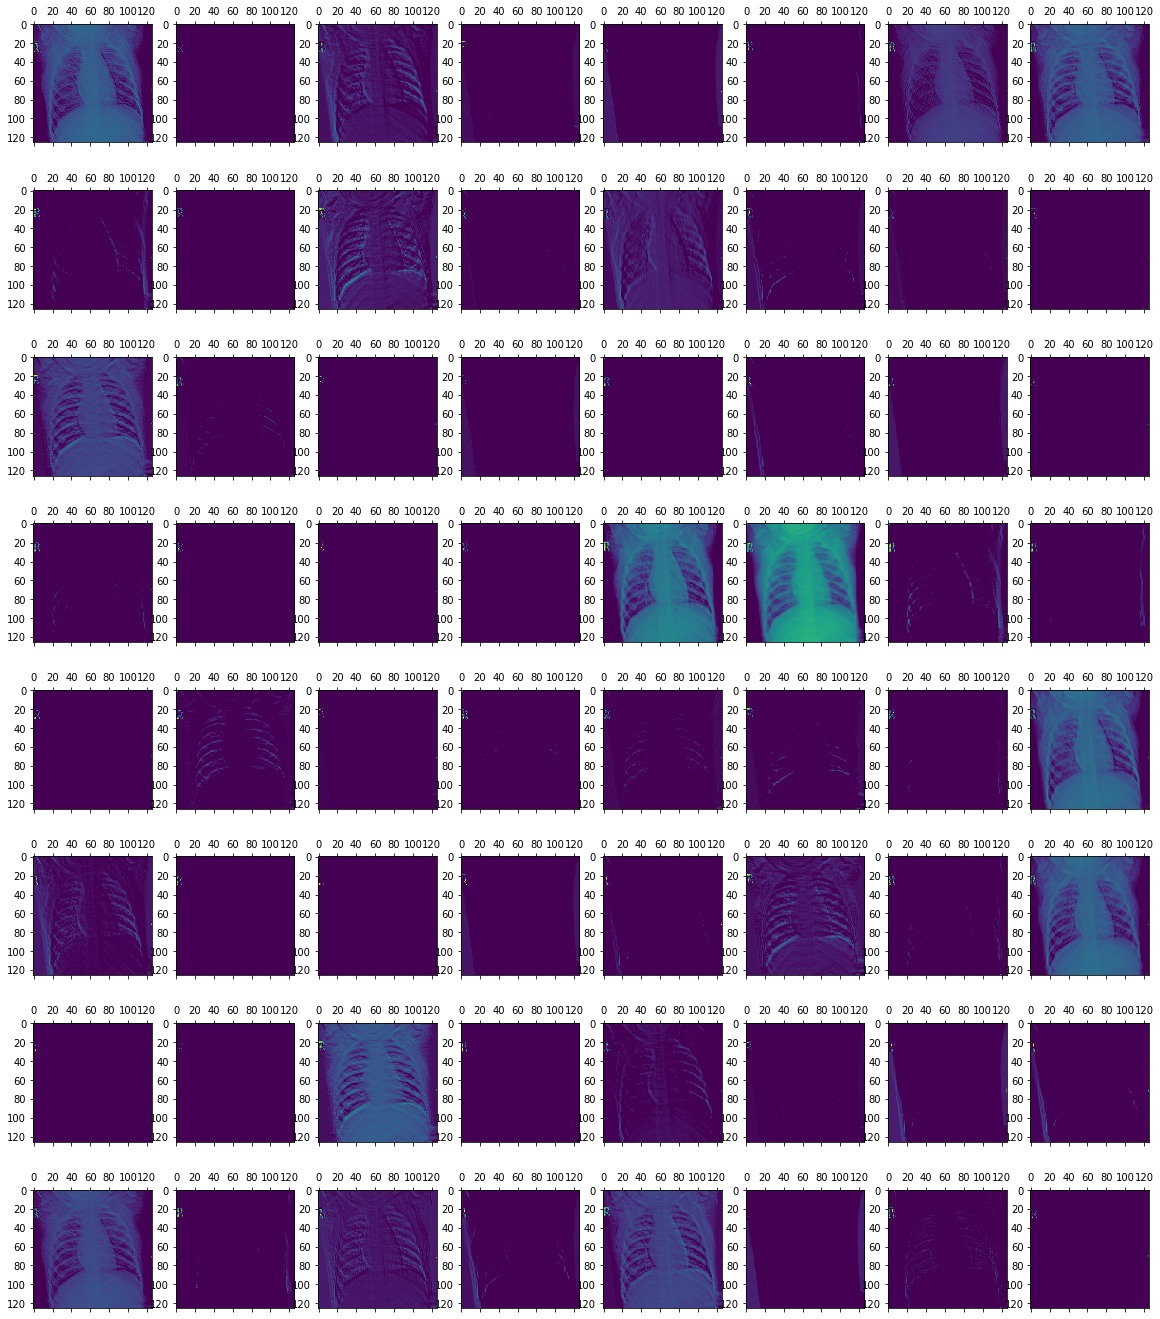

In [430]:
###TTOOODDDOOOOO: update with final model

# Visualize all 64 channels from first activation layer
fig, axes = plt.subplots(8, 8, figsize=(20,24))
for i in range(64):
    row = i//8
    column = i%8
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

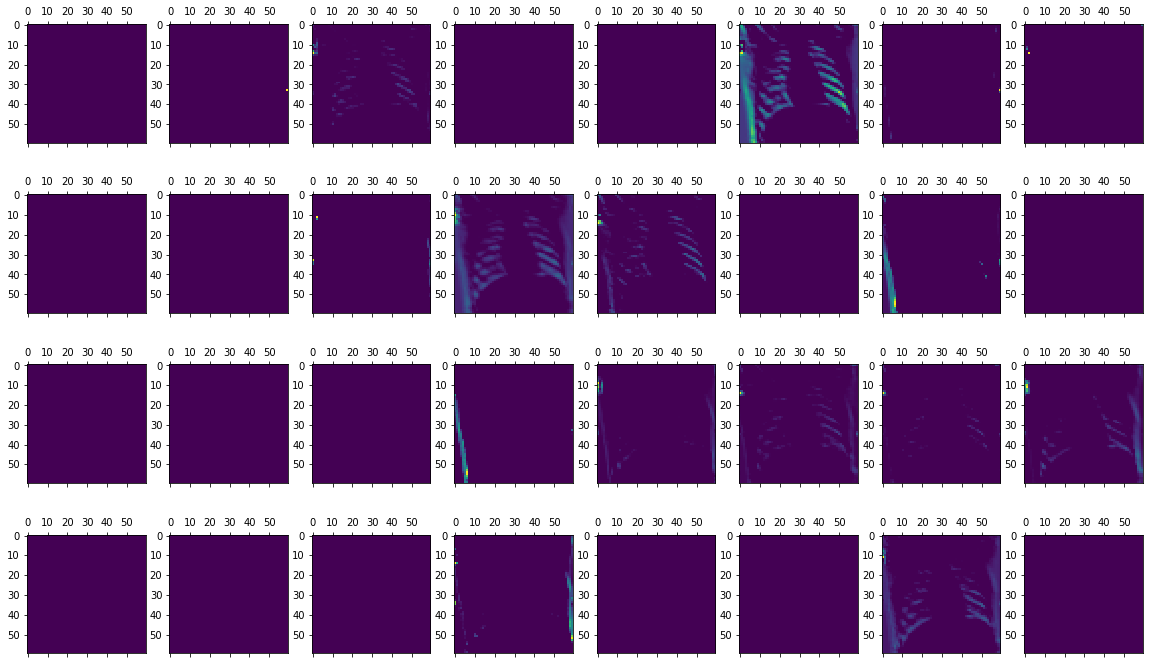

In [429]:
# Visualize all 32 channels from fourth activation layer
fig, axes = plt.subplots(4, 8, figsize=(20,12))
for i in range(32):
    row = i//8
    column = i%8
    ax = axes[row, column]
    first_layer_activation = activations[3]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

### Image explanation with LIME

val image 3
Prediction: NORMAL
Actual: NORMAL


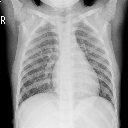

Correct!


In [401]:
###TTOOODDDOOOOO: update with final model

# Predict label and preview image
pred = int(cnn1.predict(np.array([img])).round())
print(f"val image {i}")
print("Prediction:", pred_key.get(pred))
print("Actual:", pred_key.get(label))
display(array_to_img(img))
print("Correct!") if pred_key.get(label) == pred_key.get(pred) else print("Incorrect!")

In [390]:
# Make an explainer of image patterns identified (HOW is model working?)
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(img, cnn1.predict, top_labels=2,
                                         hide_color=None, num_samples=2000)

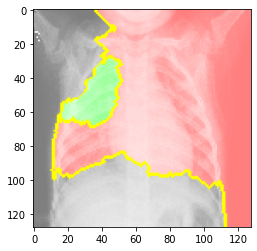

In [399]:
# Select the same class explained by the image
class_exp =  explanation.top_labels[0]

# View the explainer over the image
temp, mask = explanation.get_image_and_mask(class_exp, 
                                            positive_only=False,
                                            num_features=5)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask));

Green shows what posittively contributed towards class prediction and red shows what negatively contributed (or contributed towards non-predicted class). Essentially green is the greatest 'pro' superpixel and red is the greatest'con' superpixel towards the finalized prediction. The larger superpixel indicates the predicted class (red: 0, normal; or green: 1, pneumonia).

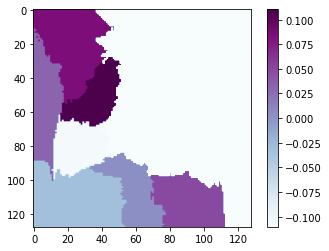

In [396]:
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[class_exp])
exp_map = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot, colorbar indications superpixel weights
plt.imshow(exp_map, cmap = 'BuPu', vmin  = -exp_map.max(), vmax = exp_map.max())
plt.colorbar()

This heatmap shows the segments learned by the model. The darker colors are the high positive (class 1, pneumonia) weights and the lighter colors indicate the negative class (0, normal). The red/green overlay on the x-ray show weights greater than (absolute) 0.1.

# Conclusion

***TODO summarize findings, give 3 reccomendations related to business problem and model performance


Possible reccomendations: disuss lowest image quality hat delivered results (can reduce from jump to minimize storage), recs on HOW to use model?

Be sure notebook answers these questions with clarity:

•	"How did you pick the question(s) that you did?"

•	"Why are these questions important from a business perspective?"

•	"How did you decide on the data cleaning options you performed?"

•	"Why did you choose a given method or library?"

•	"Why did you select these visualizations and what did you learn from each of them?"

•	"Why did you pick those features as predictors?"

•	"How would you interpret the results?"

•	"How confident are you in the predictive quality of the results?"

•	"What are some of the things that could cause the results to be wrong?"
